In [948]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
%matplotlib inline
import sys
sys.path.append ( "..")
import gp_emulator
import prosail
sys.path.insert(0,'python')
from fastRWpkl import *
from scipy import interpolate
import pandas as pd
from glob import glob
import csv
from scipy import optimize
import multiprocessing
from scipy import signal
import scipy
import tifffile as tiff
from readSent import *

In [7]:
parameters = [ 'n', 'cab', 'car', 'cbrown', 'cw', 'cm', 'lai', 'ala', 'bsoil', 'psoil']
min_vals = [ 0.8       ,  0.46301307,  0.95122942,  0.        ,  0.02829699,
            0.03651617,  0.04978707,  0.44444444,  0.        ,  0.]
max_vals = [ 2.5       ,  0.998002  ,  1.        ,  1.        ,  0.80654144,
            0.84366482,  0.99501248,  0.55555556,  2.   , 1     ]

In [22]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
%matplotlib inline
import sys
sys.path.append ( "..")
import gp_emulator


def plot_config ():
    """Update the MPL configuration"""
    config_json='''{
            "lines.linewidth": 2.0,
            "axes.edgecolor": "#bcbcbc",
            "patch.linewidth": 0.5,
            "legend.fancybox": true,
            "axes.color_cycle": [
                "#FC8D62",
                "#66C2A5",
                "#8DA0CB",
                "#E78AC3",
                "#A6D854",
                "#FFD92F",
                "#E5C494",
                "#B3B3B3"
            ],
            "axes.facecolor": "w",
            "axes.labelsize": "large",
            "axes.grid": false,
            "patch.edgecolor": "#eeeeee",
            "axes.titlesize": "x-large",
            "svg.embed_char_paths": "path",
            "xtick.direction" : "out",
            "ytick.direction" : "out",
            "xtick.color": "#262626",
            "ytick.color": "#262626",
            "axes.edgecolor": "#262626",
            "axes.labelcolor": "#262626",
            "axes.labelsize": 12,
            "font.size": 12,
            "legend.fontsize": 12,
            "xtick.labelsize": 12,
            "ytick.labelsize": 12
            
    }
    '''
    plt.rcParams['xtick.major.size'] = 10
    plt.rcParams['xtick.major.width'] = 0.5
    plt.rcParams['xtick.minor.size'] = 10
    plt.rcParams['xtick.minor.width'] = 0.5
    plt.rcParams['ytick.major.size'] = 10
    plt.rcParams['ytick.major.width'] = 0.5
    plt.rcParams['ytick.minor.size'] = 10
    plt.rcParams['ytick.minor.width'] = 0.5
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Helvetica']

    s = json.loads ( config_json )
    plt.rcParams.update(s)
    plt.rcParams["axes.formatter.limits"] = [-5,5]
    

def pretty_axes( ax ):
    """This function takes an axis object ``ax``, and makes it purrty.
    Namely, it removes top and left axis & puts the ticks at the
    bottom and the left"""

    ax.spines["top"].set_visible(False)  
    ax.spines["bottom"].set_visible(True)  
    ax.spines["right"].set_visible(False)              
    ax.spines["left"].set_visible(True)  

    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()  
    loc = plt.MaxNLocator( 6 )
    ax.yaxis.set_major_locator( loc )
    ax.xaxis.set_major_locator( loc )
    

    ax.tick_params(axis="both", which="both", bottom="on", top="off",  
            labelbottom="on", left="on", right="off", labelleft="on")  

plot_config()

/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [8]:
sza = 30.
vza = 0.
raa = 0. # in degrees
import prosail

def inverse_transform ( x ):
    """Inverse transform the PROSAIL parameters"""
    x_out = x*1.
    # Cab, posn 1
    x_out[1] = -100.*np.log ( x[1] )
    # Cab, posn 2
    x_out[2] = -100.*np.log ( x[2] )
    # Cw, posn 4
    x_out[4] = (-1./50.)*np.log ( x[4] )
    #Cm, posn 5
    x_out[5] = (-1./100.)*np.log ( x[5] )
    # LAI, posn 6
    x_out[6] = -2.*np.log ( x[6] )
    # ALA, posn 7
    x_out[7] = 90.*x[7]
    return x_out



def rt_model ( x, passband=None, do_trans=True ):
    """A coupled land surface/atmospheric model, predicting refl from
    land surface parameters. Thisfunction provides estimates of refl for 
    a particular illumination geometry.
    
    The underlying land surface reflectance spectra is simulated using
    PROSAIL. The input parameter ``x`` is a vector with the following components:
        
        * ``n``
        * ``cab``
        * ``car``
        * ``cbrown``
        * ``cw``
        * ``cm``
        * ``lai``
        * ``ala``
        * ``bsoil``
        * ``psoil``

    """
    x, sza, vza, raa = x

    # Invert parameter LAI
    if do_trans:
        x = inverse_transform ( x )
    ################# surface refl with prosail #####################
    surf_refl = prosail.run_prosail(x[0], x[1], x[2], x[3], \
        x[4], x[5], x[6], x[7], 0, x[8], x[9], 0.01, sza, vza, raa, 2 )
    
    if passband is None:
        return surf_refl
    else:
        return surf_refl[passband].mean()


In [9]:
from functools import partial
b_min = np.array( [ 620., 841, 459, 545, 1628, 2105] )
b_max = np.array( [ 670., 876, 479, 565, 1652, 2155] )
wv = np.arange ( 400, 2501 )
passband = []

n_train = 300
n_validate = 1000

retval = []
for iband,bmin in enumerate ( b_min ):
    print "Doing band %d" % (iband+1)
    passband = np.nonzero( np.logical_and ( wv >= bmin, wv <= b_max[iband] ) )
    simulator = partial ( rt_model, passband=passband )
    x = gp_emulator.create_emulator_validation ( simulator, parameters, min_vals, max_vals, 
                                n_train, n_validate, do_gradient=True, 
                                n_tries=15, args=(30, 0, 0) )
    retval.append ( x )

Doing band 1
After 15, the minimum cost was -1.079046e+03
Doing band 2
After 15, the minimum cost was -1.136755e+03
Doing band 3


/home/ucfafyi/.local/lib/python2.7/site-packages/gp_emulator/GaussianProcess.py:176: RuntimeWarning: Optimisation resulted in linear algebra error. Returning last loglikelihood calculated, but this is fishy
  RuntimeWarning )


After 15, the minimum cost was -1.207325e+03
Doing band 4
After 15, the minimum cost was -1.066286e+03
Doing band 5
After 15, the minimum cost was -1.061250e+03
Doing band 6
After 15, the minimum cost was -1.157556e+03


1 &  0.989 &  0.001 &  0.997 & 2.232e-03 & 7.104e-02\\
2 &  0.997 &  0.001 &  1.000 & 7.526e-04 & 2.507e-02\\
3 &  0.985 &  0.001 &  0.997 & 2.437e-03 & 7.558e-02\\
4 &  0.998 &  0.001 &  0.998 & 1.938e-03 & 3.424e-02\\
5 &  0.998 &  0.000 &  1.000 & 7.401e-04 & 1.741e-02\\
6 &  1.001 & -0.000 &  1.000 & 5.881e-04 & 2.283e-02\\


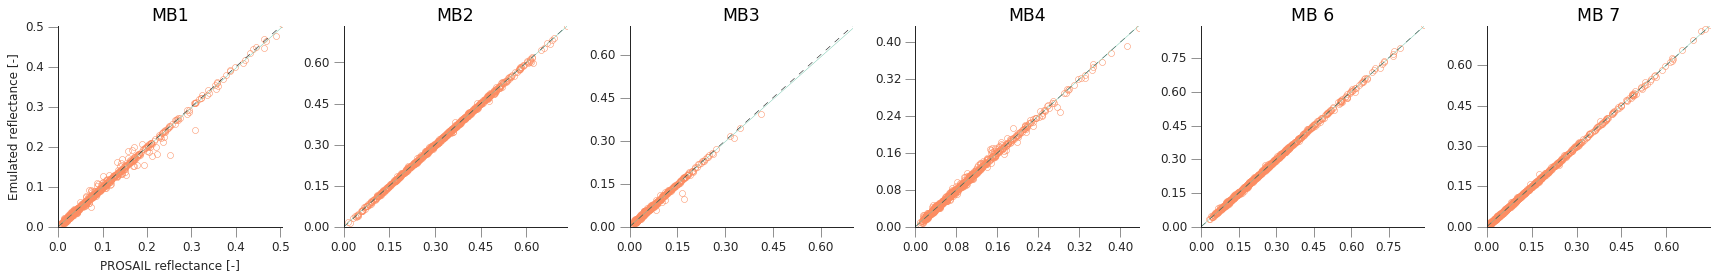

In [35]:
fig1, axs1 = plt.subplots ( nrows=1, ncols=6, figsize=(24,4))
#fig2, axs2 = plt.subplots ( nrows=4, ncols=3, figsize=(9,9))
axs1 = axs1.flatten()
#axs2 = axs2.flatten()
for iband in xrange ( 6):
    gp, validate, validate_output, validate_gradient, emulated_validation, emulated_gradient = retval[iband]

    slope, intercept, r_value, p_value, std_err = linregress( validate_output, emulated_validation.squeeze() )
    axs1[iband].plot ( validate_output, emulated_validation, 'o', mec="#FC8D62", mfc="none", rasterized=True )
    ymax = np.max ( validate_output.max(), emulated_validation.max() )
    if iband == 2:
        ymax = ymax*1.7
    axs1[iband].plot ( [0, 1.2*ymax], [0, 1.2*ymax], 'k--', lw=0.5)
    p = np.polyfit ( validate_output, emulated_validation, 1)
    mae = np.abs(validate_output- emulated_validation.squeeze()).max()
    print "%d & %6.3f & %6.3f & %6.3f & %6.3e & %6.3e\\\\" % (iband+1, slope, intercept, r_value, std_err, mae),
    x = np.linspace(0, 1.2*ymax, 5)
    axs1[iband].plot ( x, np.polyval ( p, x), '-', lw=0.4  )
    axs1[iband].set_ylim ( 0, ymax )
    axs1[iband].set_xlim ( 0, ymax )
    pretty_axes ( axs1[iband])
    if iband >=4:
        axs1[iband].set_title ( "MB %d" % (iband+2))
    else:
        axs1[iband].set_title ( "MB%d" % (iband+1))
    print
axs1[0].set_ylabel ( "Emulated reflectance [-]")
axs1[0].set_xlabel ( "PROSAIL reflectance [-]")
plt.tight_layout()
#axs1[6].set_visible (False)
#axs1[7].set_visible (False)
#axs1[8].set_visible (False)

In [ ]:
from functools import partial
b_min = np.array( [  459, 545, 620., 841, 1628, 2105, 457.5,   542.5,   650. ,   784.5,   855. ,  1565. ,  2100.] )
b_max = np.array( [  479, 565, 670., 876, 1652, 2155, 522.5,   577.5,   680. ,   899.5,   875. ,  1655. ,  2280.] )
wv = np.arange ( 400, 2501 )
passband = []

n_train = 300
n_validate = 10000

retval = []
for iband,bmin in enumerate ( b_min ):
    print "Doing band %d" % (iband+1)
    #passband = np.nonzero( np.logical_and ( wv >= bmin, wv <= b_max[iband] ) )
    simulator = partial ( rt_model, passband=passband)
    x = gp_emulator.create_emulator_validation ( simulator, parameters, min_vals, max_vals, 
                                n_train, n_validate, do_gradient=True, 
                                n_tries=15, args=(30, 0, 0) )
    retval.append (x)

In [38]:
n_train = 300
n_validate = 10000
x = gp_emulator.create_emulator_validation ( rt_model, parameters, min_vals, max_vals, 
                                n_train, n_validate, do_gradient=True, 
                                n_tries=15, args=(30, 0, 0) )

Decomposing the input dataset into basis functions... Done!
 ====> Using 8 basis functions
	Fitting GP for basis function 0
After 15, the minimum cost was 4.910229e+01
	Fitting GP for basis function 1
After 15, the minimum cost was -9.272220e+01
	Fitting GP for basis function 2
After 15, the minimum cost was -1.248807e+02
	Fitting GP for basis function 3
After 15, the minimum cost was -2.643745e+02
	Fitting GP for basis function 4
After 15, the minimum cost was -3.478638e+02
	Fitting GP for basis function 5
After 15, the minimum cost was -5.853321e+02
	Fitting GP for basis function 6
After 15, the minimum cost was -5.473768e+02
	Fitting GP for basis function 7
After 15, the minimum cost was -5.394277e+02


In [421]:
x = parallel_rw_pkl(None,'emulation', 'r')

In [ ]:
residual = x[2] - x[4]

([<matplotlib.axis.YTick at 0x7f18f853f850>,
 <a list of 5 Text yticklabel objects>)

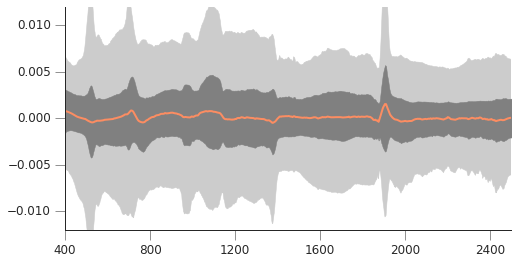

In [55]:
wv = np.arange ( 400, 2501 )
plt.figure(figsize=(8,4))
plt.plot ( wv, residual.mean(axis=0))
plt.fill_between( wv, np.percentile( residual, 5, axis=0 ), 
                 np.percentile( residual, 95, axis=0 ), color="0.8")
plt.fill_between( wv, np.percentile( residual, 25, axis=0 ), 
                 np.percentile( residual, 75, axis=0 ), color="0.5")
plt.xlim(400,2500)
plt.ylim ( -0.012, 0.012)

pretty_axes(plt.gca())
plt.yticks([-0.01, -0.005, 0, 0.005, 0.01])

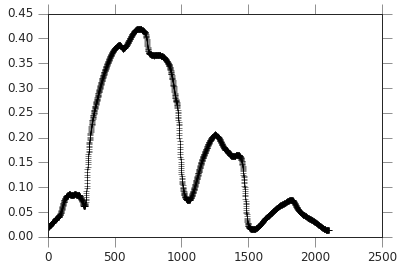

In [69]:
plt.plot(x[2][-1], 'k+')

In [129]:
wv = np.arange ( 400, 2501 )
b_min = np.array( [  459, 545, 620., 841, 1628, 2105, 457.5,   542.5,   650. ,   784.5,   855. ,  1565. ,  2100.] )
b_max = np.array( [  479, 565, 670., 876, 1652, 2155, 522.5,   577.5,   680. ,   899.5,   875. ,  1655. ,  2280.] )
pbands = []
for iband,bmin in enumerate ( b_min ):
    passband = np.nonzero( np.logical_and ( wv >= bmin, wv <= b_max[iband] ) )
    pbands.append(passband)

In [136]:
to_reg = []
for i in range(7):
    if i<=3:
        to_reg.append([x[2].T[pbands[i]],x[2].T[pbands[i+6]]])
    else:
        to_reg.append([x[2].T[pbands[i-1]],x[2].T[pbands[i+6]]])

In [156]:
mod = np.mean(to_reg[6][0], axis=0)
sen = np.mean(to_reg[6][1], axis=0)

LinregressResult(slope=0.98609631038041534, intercept=0.0044882847657742586, rvalue=0.99971825065094111, pvalue=0.0, stderr=0.00023415369360466041)


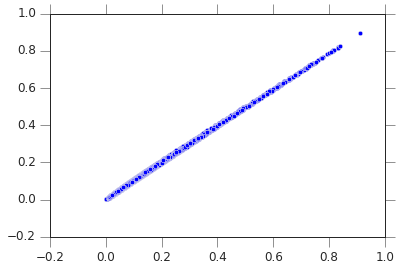

In [157]:
plt.scatter(mod, sen)
print linregress(mod, sen)

The spectral response is not mean of the values within that instead the relative spectral response is used.

In [175]:
mod_spr = '''modis_band1.det  modis_band3.det  modis_band6.det  modis_band2.det  modis_band4.det  modis_band7.det'''.split('  ')

In [518]:
sorted(mod_spr)

['modis_band1.det',
 'modis_band2.det',
 'modis_band3.det',
 'modis_band4.det',
 'modis_band6.det',
 'modis_band7.det']

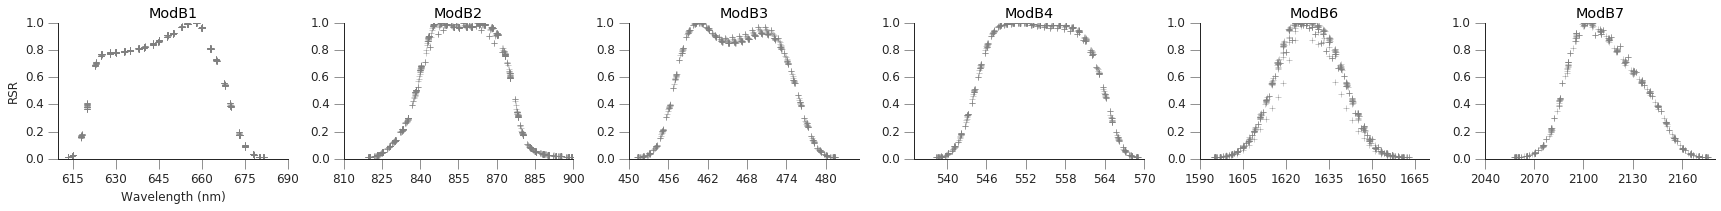

In [520]:
fig = plt.figure(figsize = (24,3))
mod_spr = sorted(mod_spr)
for i,j in enumerate(mod_spr):
    ax = fig.add_subplot(1,6,i+1)
    wl,re= np.loadtxt('sp_rep/'+j).T[2:]
    ax.plot(wl, re, '+',color='gray', alpha=0.8)
    if i >=4:
        ax.set_title ( "ModB%d" % (i+2))
    else:
        ax.set_title ( "ModB%d" % (i+1))
    pretty_axes(ax)
    ax.set_yticks(np.arange(0,1.2,0.2))
    if i==0:
        ax.set_xlabel ( "Wavelength (nm)")
        ax.set_ylabel ( "RSR")
plt.tight_layout()

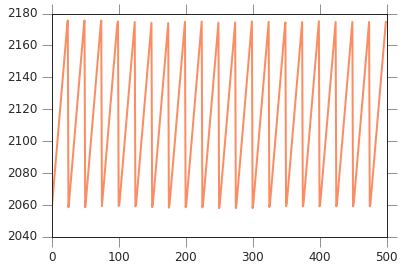

In [237]:
plt.plot(wl)

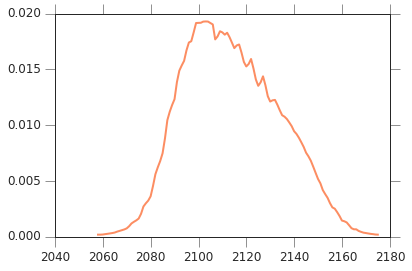

In [333]:
plt.plot(xnew, ynew/(ynew.sum()), '-')

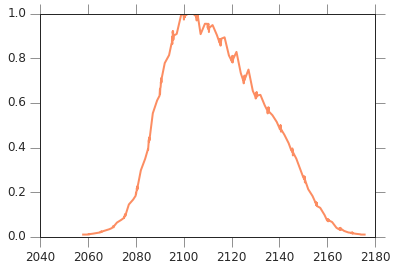

In [330]:
plt.plot(w,r)

In [350]:
sen_rsp = pd.ExcelFile('sp_rep/Sentbands.xlsx')
sen_rsp.sheet_names

[u'Overview',
 u'Spectral Responses',
 u'VNIR Spectral Responses Chart',
 u'SWIR Spectral Responses Chart']

In [360]:
sen_rsp.parse('Spectral Responses').head()

,SR_WL,SR_AV_B1,SR_AV_B2,SR_AV_B3,SR_AV_B4,SR_AV_B5,SR_AV_B6,SR_AV_B7,SR_AV_B8,SR_AV_B8A,SR_AV_B9,SR_AV_B10,SR_AV_B11,SR_AV_B12
0,300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


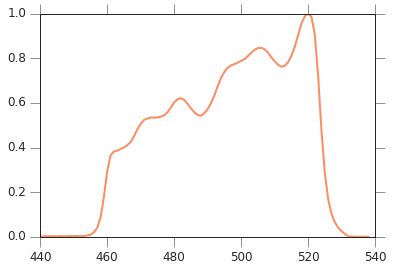

In [385]:
plt.plot(swl[srsp!=0],srsp[srsp!=0])

In [386]:
cname= 'SR_AV_B2', 'SR_AV_B3', 'SR_AV_B4', 'SR_AV_B8', 'SR_AV_B8A', 'SR_AV_B11', 'SR_AV_B12'

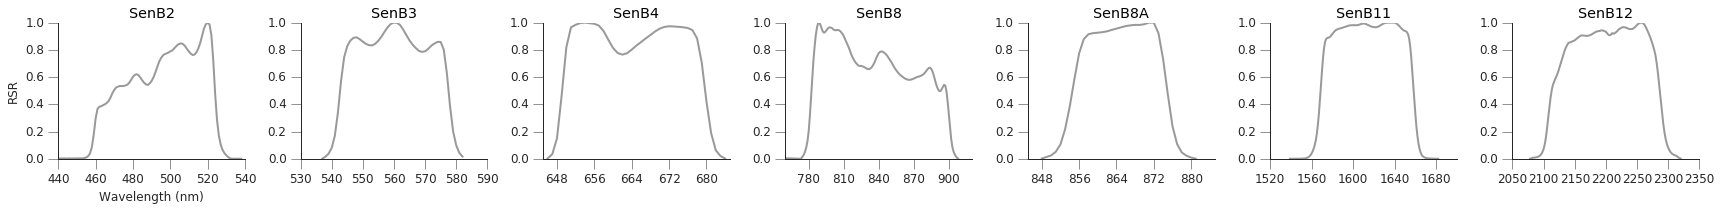

In [417]:
swl = np.array(sen_rsp.parse('Spectral Responses')['SR_WL'])
fig = plt.figure(figsize = (24,3))
for i in range(7): 
    srsp = np.array(sen_rsp.parse('Spectral Responses')[cname[i]])
    ax = fig.add_subplot(1,7,i+1)
    ax.plot(swl[srsp!=0],srsp[srsp!=0], '-', color='gray', alpha=0.8)
    ax.set_title('Sen%s'%(cname[i][6:]))
    pretty_axes(ax)
    ax.set_yticks(np.arange(0,1.1,0.2))
    if i==0:
        ax.set_xlabel ( "Wavelength (nm)")
        ax.set_ylabel ( "RSR")
plt.tight_layout()

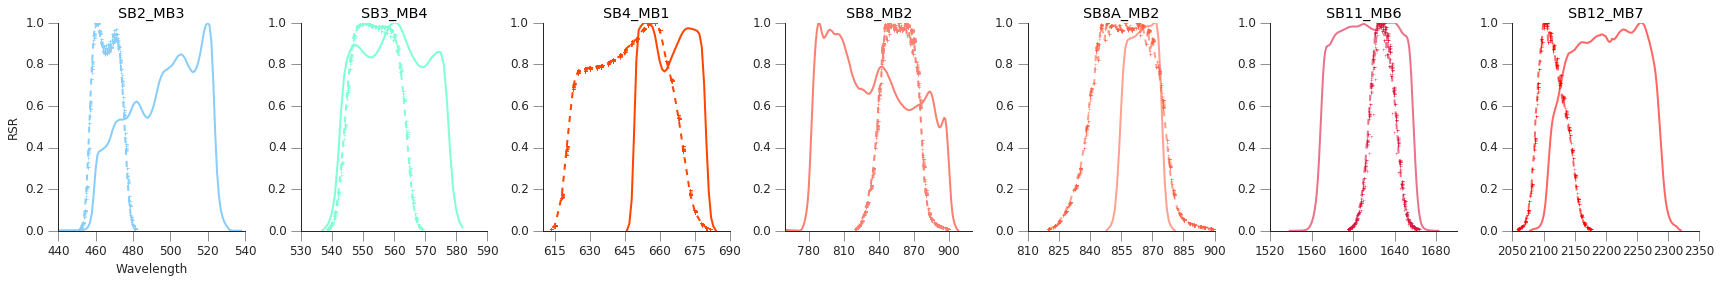

In [640]:
mod_spr = '''modis_band1.det  modis_band3.det  modis_band6.det  modis_band2.det  modis_band4.det  modis_band7.det'''.split('  ')
mod_spr = sorted(mod_spr)
sen_rsp = pd.ExcelFile('sp_rep/Sentbands.xlsx')
swl = np.array(sen_rsp.parse('Spectral Responses')['SR_WL'])
fig = plt.figure(figsize=(24,4))
colors='lightskyblue', 'aquamarine', 'orangered', 'salmon', 'tomato', 'crimson', 'red'
for ii in range(7):
    if ii<2:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii+2]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
    elif ii<4:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii-2]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
    elif ii==4:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii-3]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
    else:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii-1]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
    srsp = np.array(sen_rsp.parse('Spectral Responses')[cname[ii]])
    ax = fig.add_subplot(1,7,ii+1)
    if ii>3:
        alp=0.6
    else:
        alp=1
    ax.plot(swl[srsp!=0], srsp[srsp!=0],color=colors[ii],alpha=alp )
    ax.plot(wl, re, '+', color=colors[ii],alpha=alp,  ms=3)
    ax.plot(xnew, ynew, '--',color=colors[ii], alpha=alp)
    pretty_axes(ax)
    ax.set_title(names[ii])
    ax.set_yticks(np.arange(0,1+0.1,1/5.))
    #ax.set_xticks(np.arange(0,1+0.1,1/5.))
    if ii==0:
        ax.set_xlabel ( "Wavelength")
        ax.set_ylabel ( "RSR")
plt.tight_layout()

In [521]:
mod_spr

['modis_band1.det',
 'modis_band2.det',
 'modis_band3.det',
 'modis_band4.det',
 'modis_band6.det',
 'modis_band7.det']

slope:  1.0411 intercept:  0.0077 rvalue:  0.9905 pvalue:  0.0 stderr:  0.0014
slope:  1.0119 intercept:  -0.0021 rvalue:  0.9997 pvalue:  0.0 stderr:  0.0002
slope:  1.0197 intercept:  -0.0035 rvalue:  0.9973 pvalue:  0.0 stderr:  0.0008
slope:  0.9651 intercept:  0.001 rvalue:  0.9991 pvalue:  0.0 stderr:  0.0004
slope:  1.0106 intercept:  -0.0004 rvalue:  0.9999 pvalue:  0.0 stderr:  0.0001
slope:  0.9967 intercept:  -0.0057 rvalue:  0.9998 pvalue:  0.0 stderr:  0.0002
slope:  0.9873 intercept:  0.008 rvalue:  0.999 pvalue:  0.0 stderr:  0.0004


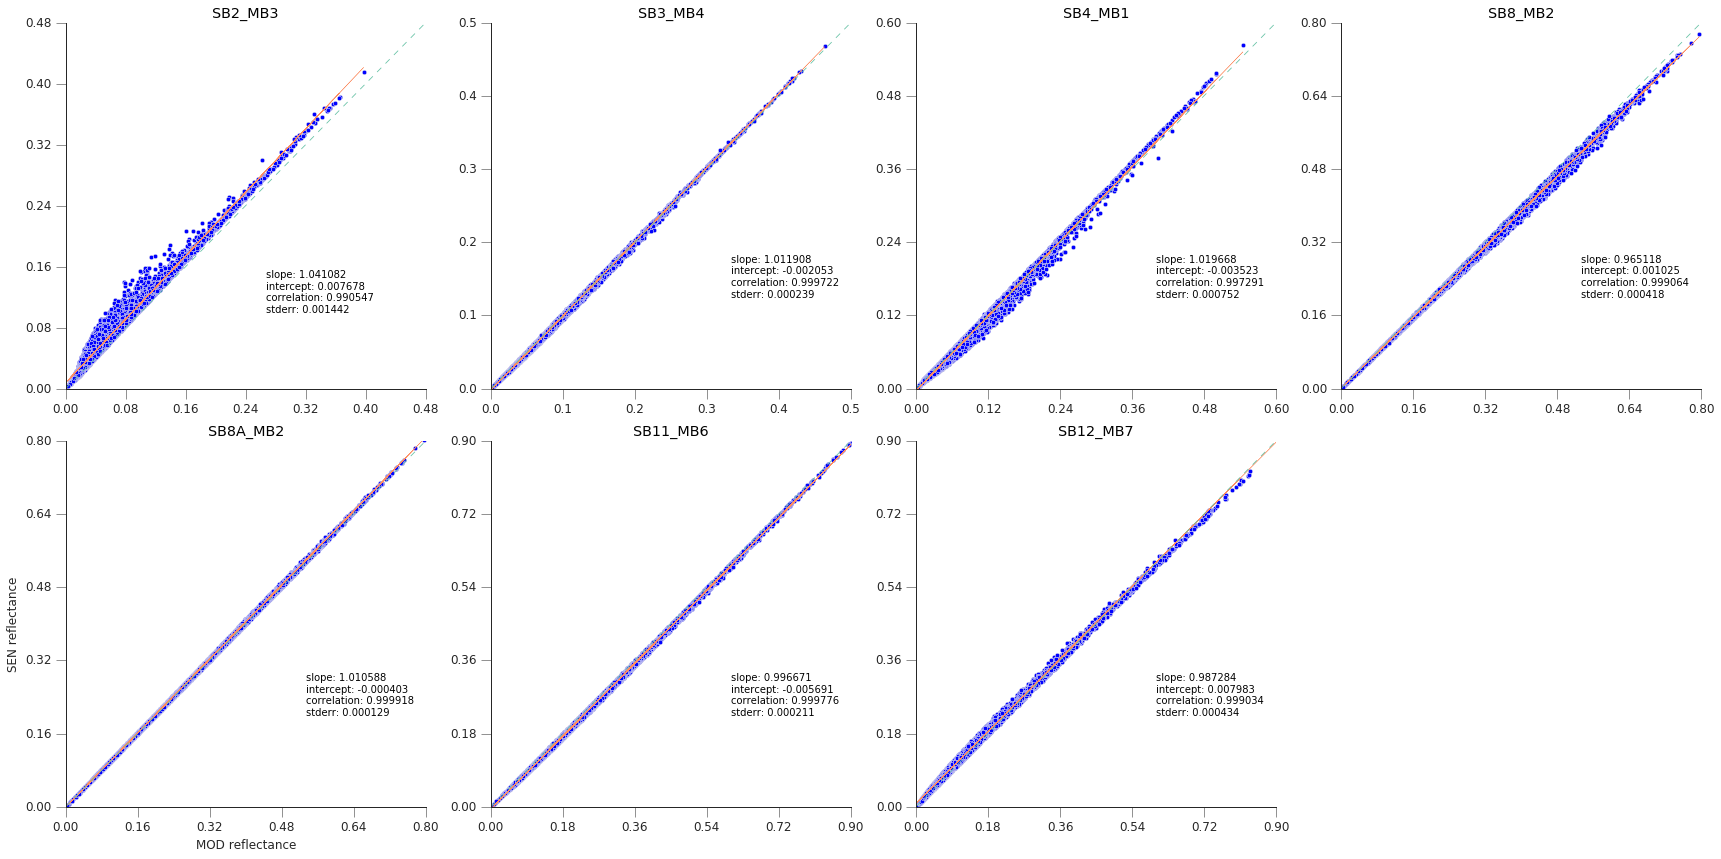

In [634]:
spec = x
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8A_MB2,SB11_MB6,SB12_MB7').split(',')
mod_spr = '''modis_band1.det  modis_band3.det  modis_band6.det  modis_band2.det  modis_band4.det  modis_band7.det'''.split('  ')
mod_spr = sorted(mod_spr)
sen_rsp = pd.ExcelFile('sp_rep/Sentbands.xlsx')
swl = np.array(sen_rsp.parse('Spectral Responses')['SR_WL'])
fig = plt.figure(figsize=(24,12))
for ii in range(7):
    if ii<2:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii+2]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
    elif ii<4:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii-2]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
    elif ii==4:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii-3]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
    else:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii-1]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
         
    
    srsp = np.array(sen_rsp.parse('Spectral Responses')[cname[ii]])[100:2201]
    #w, rsr = swl[srsp!=0],srsp[srsp!=0]
    #passband2 = swl[100:2200]
    mod = np.sum(spec[2].T[passband1].T*(ynew/ynew.sum()), axis=-1)
    sen = np.sum(spec[2]*(srsp/srsp.sum()), axis=-1)
    p = np.polyfit (mod, sen, 1)
    ax = fig.add_subplot(2,4,ii+1)
    ax.scatter(mod,sen, marker='o')
    mval = round(np.max([mod, sen]), 1)
    pretty_axes(ax)
    ax.plot( mod, np.polyval ( p, mod), '-', lw=0.4  )
    ax.plot([0,mval+0.1], [0,mval+0.1], '--', lw=0.8)
    ax.set_title(names[ii])
    ax.set_xlim(0,mval)
    ax.set_ylim(0,mval)
    ax.set_yticks(np.arange(0,mval+0.1,mval/5.))
    ax.set_xticks(np.arange(0,mval+0.1,mval/5.))
    slope,inter, rval, pval, std = linregress(mod, sen)
    ax.text(mval*(4./6.),mval*(1.5/6.),'slope: %02f \nintercept: %02f \ncorrelation: %02f \nstderr: %02f'%(slope,inter, rval, std), 
        )
    if ii==4:
        ax.set_xlabel ( "MOD reflectance")
        ax.set_ylabel ( "SEN reflectance")
    print 'slope: ',round(slope,4), 'intercept: ', round(inter,4), 'rvalue: ',round(rval,4), 'pvalue: ', round(pval,4), 'stderr: ', round(std,4)
plt.tight_layout()

#### Using the in situ maasurements

In [762]:
fnames = glob('spectral/*.*')

In [774]:
insitu=[]
for fname in fnames:
    for i in range(100):
        try:
            data = np.loadtxt(fname, skiprows=i).T
            break
        except:
            continue
    
    dat = {j:data[1][i] for i, j in enumerate(data[0])}
    w,r = np.array([[i,dat[i]] for i in sorted(dat.keys())]).T
    if w[0]<200:
        w=w*1000
    f = interpolate.interp1d(w,r)
    wvmin = np.ceil(max(400,min(w))).astype(int)
    wvmax = min(int(max(w)), 2500)
    xnew=range(wvmin, wvmax)
    ynew = f(xnew)
    fspec = np.zeros(len(wv))
    if max(ynew)>1:
        ynew=ynew/100.
    ynew[ynew<0]=0
    fspec[wvmin-400:wvmax-400]=ynew
    insitu.append(fspec)

In [775]:
insitu

[array([ 0.00013514,  0.00017334,  0.00021957, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.00029033,  0.00039267,  0.00043198, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.00225277,  0.00239528,  0.00246895, ...,  0.        ,
         0.        ,  0.        ]),
 array([  2.50729730e-05,   8.21315789e-05,   9.24837838e-05, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]),
 array([  6.26297297e-06,   1.06105263e-05,   8.69189189e-06, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]),
 array([  0.00000000e+00,   1.79052632e-06,   7.28216216e-06, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]),
 array([  9.38135135e-05,   1.90336737e-04,   2.48576108e-04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.00020442,  0.00035179,  0.00048623, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.,  0.,  0., ...,

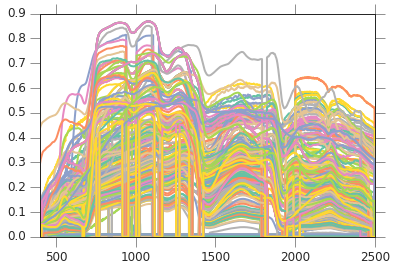

In [776]:
for i in range(len(fnames)):
    plt.plot(wv, np.array(insitu)[i])
    plt.xlim(400,2501)

In [783]:
x[2].shape

(10000, 2101)

slope:  1.0631 intercept:  0.0052 rvalue:  0.9946 pvalue:  0.0 stderr:  0.0061
slope:  1.0037 intercept:  0.0009 rvalue:  0.9997 pvalue:  0.0 stderr:  0.0015
slope:  1.0254 intercept:  -0.0027 rvalue:  0.9984 pvalue:  0.0 stderr:  0.0033
slope:  0.9962 intercept:  -0.0036 rvalue:  0.9999 pvalue:  0.0 stderr:  0.0009
slope:  1.002 intercept:  0.0012 rvalue:  0.9999 pvalue:  0.0 stderr:  0.0005
slope:  1.0003 intercept:  -0.0045 rvalue:  0.9998 pvalue:  0.0 stderr:  0.0012
slope:  0.9773 intercept:  0.0068 rvalue:  0.9989 pvalue:  0.0 stderr:  0.0028


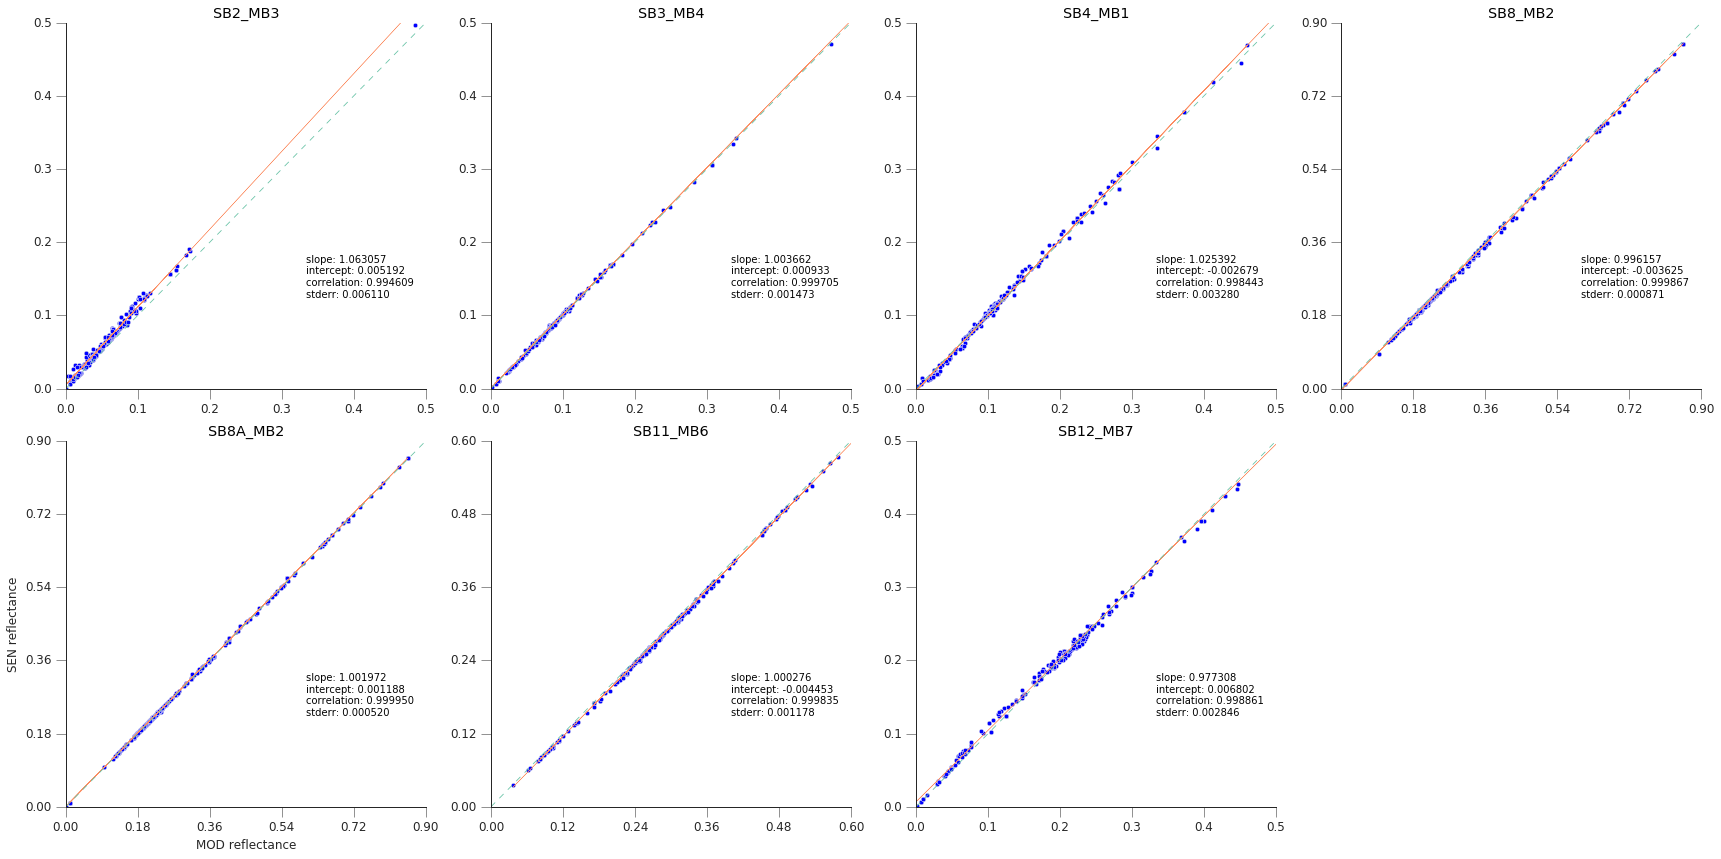

In [881]:
spec2 =  np.array(insitu)
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8A_MB2,SB11_MB6,SB12_MB7').split(',')
mod_spr = '''modis_band1.det  modis_band3.det  modis_band6.det  modis_band2.det  modis_band4.det  modis_band7.det'''.split('  ')
mod_spr = sorted(mod_spr)
sen_rsp = pd.ExcelFile('sp_rep/Sentbands.xlsx')
swl = np.array(sen_rsp.parse('Spectral Responses')['SR_WL'])
fig = plt.figure(figsize=(24,12))
for ii in range(7):
    if ii<2:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii+2]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
    elif ii<4:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii-2]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
    elif ii==4:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii-3]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
    else:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii-1]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
         
    
    srsp = np.array(sen_rsp.parse('Spectral Responses')[cname[ii]])[100:2201]
    #w, rsr = swl[srsp!=0],srsp[srsp!=0]
    #passband2 = swl[100:2200]
    mod = np.sum(spec2.T[passband1].T*(ynew/ynew.sum()), axis=-1)
    sen = np.sum(spec2*(srsp/srsp.sum()), axis=-1)
    dis = mod-sen
    std = np.std(dis)
    mean = np.mean(dis)
    inl = (dis > mean-std)&(dis < mean+std)
    modin = mod[inl]
    senin = sen[inl]
    p = np.polyfit (modin, senin, 1)
    ax = fig.add_subplot(2,4,ii+1)
    ax.scatter(modin,senin, marker='o')
    mval = round(np.max([modin, senin]), 1)
    pretty_axes(ax)
    ax.plot( modin, np.polyval ( p, modin), '-', lw=0.4  )
    ax.plot([0,mval+0.1], [0,mval+0.1], '--', lw=0.8)
    ax.set_title(names[ii])
    ax.set_xlim(0,mval)
    ax.set_ylim(0,mval)
    ax.set_yticks(np.arange(0,mval+0.1,mval/5.))
    ax.set_xticks(np.arange(0,mval+0.1,mval/5.))
    slope,inter, rval, pval, std = linregress(modin, senin)
    ax.text(mval*(4./6.),mval*(1.5/6.),'slope: %02f \nintercept: %02f \ncorrelation: %02f \nstderr: %02f'%(slope,inter, rval, std), 
        )
    if ii==4:
        ax.set_xlabel ( "MOD reflectance")
        ax.set_ylabel ( "SEN reflectance")
    print 'slope: ',round(slope,4), 'intercept: ', round(inter,4), 'rvalue: ',round(rval,4), 'pvalue: ', round(pval,4), 'stderr: ', round(std,4)
plt.tight_layout()

In [787]:
for i in range(100):
    try:
        Hy = np.loadtxt('HyMap_NDVI_3_Threshold_v2.txt', skiprows=i).T
        break
    except:
        continue

In [792]:
hy = Hy[7:,:]

In [808]:
hywv = [0.458500, 0.472600, 0.487500, 0.502100, 0.516700, 0.531700, 0.546500,
0.561300, 0.576000, 0.590900, 0.605600, 0.620100, 0.634600, 0.649000,
0.663400, 0.678100, 0.692600, 0.707100, 0.721400, 0.735700, 0.749900,
0.764100, 0.778300, 0.792500, 0.806900, 0.821200, 0.835300, 0.849500,
0.863400, 0.877100, 0.889400, 0.904300, 0.919900, 0.935500, 0.951100,
0.966200, 0.981400, 0.996800, 1.012100, 1.027100, 1.042200, 1.057200,
1.071800, 1.086300, 1.101100, 1.115800, 1.130200, 1.144500, 1.158900,
1.173300, 1.187500, 1.201500, 1.215500, 1.229500, 1.243500, 1.257500,
1.271300, 1.285000, 1.298700, 1.312500, 1.326400, 1.390900, 1.405200,
1.420000, 1.434500, 1.448900, 1.463200, 1.477700, 1.491800, 1.505500,
1.519300, 1.533100, 1.546800, 1.560300, 1.573700, 1.586900, 1.600000,
1.613200, 1.626300, 1.639300, 1.652100, 1.664800, 1.677400, 1.690000,
1.702600, 1.715100, 1.727400, 1.739700, 1.751800, 1.764000, 1.776100,
1.788100, 1.799800, 1.951700, 1.970700, 1.989900, 2.009300, 2.028400,
2.047400, 2.066300, 2.084900, 2.103400, 2.121800, 2.139900, 2.157900,
2.175500, 2.192500, 2.211000, 2.229200, 2.246600, 2.264300, 2.281300,
2.298400, 2.315500, 2.332400, 2.349200, 2.365900, 2.382400, 2.398700,
2.415000, 2.431400, 2.447400, 2.463200, 2.479000, 2.493900]

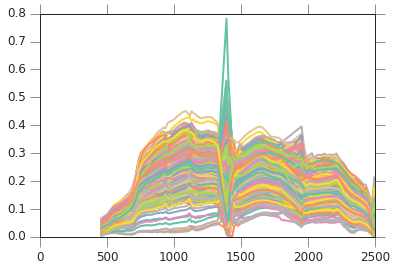

In [813]:
for i in np.random.choice(range(198443), 10000):
    if all(hy.T[i]>0):
        plt.plot(np.array(hywv)*1000, hy.T[i]/10000., '-')
    else:
        pass

In [818]:
hysp = []
for i in np.random.choice(range(198443), 10000):
    if all(hy.T[i]>0):
        f = interpolate.interp1d(np.array(hywv)*1000, hy.T[i]/10000.)
        wvmin = 459
        wvmax = 2493
        xnew = range(459,2493)
        ynew = f(xnew)
        fspec = np.zeros(len(wv))
        fspec[wvmin-400:wvmax-400]=ynew
        hysp.append(fspec)
    else:
        pass

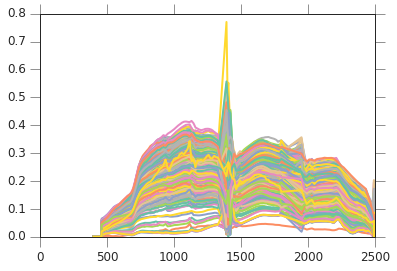

In [819]:
for i in hysp:
    plt.plot(wv, i)

slope:  1.2207 intercept:  0.0061 rvalue:  0.9882 pvalue:  0.0 stderr:  0.0032
slope:  1.0147 intercept:  0.0002 rvalue:  0.999 pvalue:  0.0 stderr:  0.0007
slope:  1.0744 intercept:  -0.0029 rvalue:  0.9973 pvalue:  0.0 stderr:  0.0013
slope:  0.962 intercept:  0.0015 rvalue:  0.9996 pvalue:  0.0 stderr:  0.0005
slope:  1.012 intercept:  -0.0003 rvalue:  0.9999 pvalue:  0.0 stderr:  0.0002
slope:  0.9901 intercept:  -0.0016 rvalue:  0.9999 pvalue:  0.0 stderr:  0.0002
slope:  0.956 intercept:  0.0028 rvalue:  0.9968 pvalue:  0.0 stderr:  0.0013


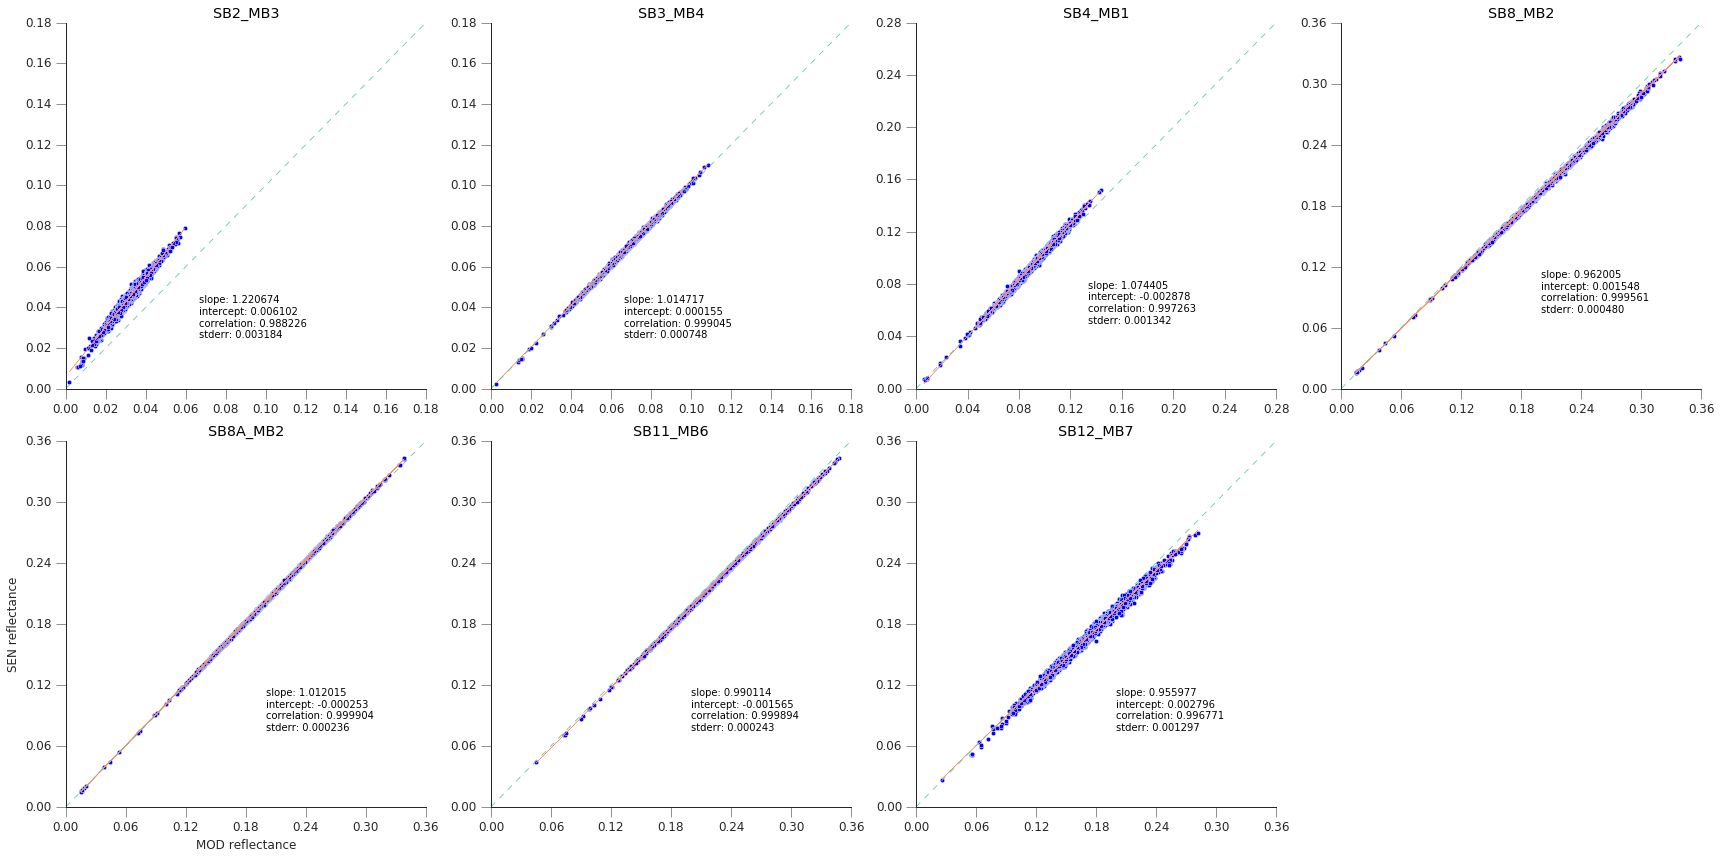

In [879]:
spec3 =  np.array(hysp)
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8A_MB2,SB11_MB6,SB12_MB7').split(',')
mod_spr = '''modis_band1.det  modis_band3.det  modis_band6.det  modis_band2.det  modis_band4.det  modis_band7.det'''.split('  ')
mod_spr = sorted(mod_spr)
sen_rsp = pd.ExcelFile('sp_rep/Sentbands.xlsx')
swl = np.array(sen_rsp.parse('Spectral Responses')['SR_WL'])
fig = plt.figure(figsize=(24,12))
for ii in range(0,7):
    if ii<2:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii+2]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
    elif ii<4:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii-2]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
    elif ii==4:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii-3]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
    else:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii-1]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
         
    
    srsp = np.array(sen_rsp.parse('Spectral Responses')[cname[ii]])[100:2201]
    #w, rsr = swl[srsp!=0],srsp[srsp!=0]
    #passband2 = swl[100:2200]
    mod = np.sum(spec3.T[passband1].T*(ynew/ynew.sum()), axis=-1)
    sen = np.sum(spec3*(srsp/srsp.sum()), axis=-1)
    p = np.polyfit (mod, sen, 1)
    ax = fig.add_subplot(2,4,ii+1)
    ax.scatter(mod,sen, marker='o')
    mval = round(np.max([mod, sen]), 1)
    pretty_axes(ax)
    ax.plot( mod, np.polyval ( p, mod), '-', lw=0.4  )
    ax.plot([0,mval+0.1], [0,mval+0.1], '--', lw=0.8)
    ax.set_title(names[ii])
    ax.set_xlim(0,mval)
    ax.set_ylim(0,mval)
    ax.set_yticks(np.arange(0,mval+0.1,mval/5.))
    ax.set_xticks(np.arange(0,mval+0.1,mval/5.))
    slope,inter, rval, pval, std = linregress(mod, sen)
    ax.text(mval*(4./6.),mval*(1.5/6.),'slope: %02f \nintercept: %02f \ncorrelation: %02f \nstderr: %02f'%(slope,inter, rval, std), 
        )
    if ii==4:
        ax.set_xlabel ( "MOD reflectance")
        ax.set_ylabel ( "SEN reflectance")
    print 'slope: ',round(slope,4), 'intercept: ', round(inter,4), 'rvalue: ',round(rval,4), 'pvalue: ', round(pval,4), 'stderr: ', round(std,4)
plt.tight_layout()

In [853]:
soil = csv.reader(open('ASDSpec.csv', 'rb'))

In [842]:
un = []
for i in soil:
    un.append(i)

In [854]:
for i in soil:
    print i 
    break

['Batch_Labid', 'W350', 'W360', 'W370', 'W380', 'W390', 'W400', 'W410', 'W420', 'W430', 'W440', 'W450', 'W460', 'W470', 'W480', 'W490', 'W500', 'W510', 'W520', 'W530', 'W540', 'W550', 'W560', 'W570', 'W580', 'W590', 'W600', 'W610', 'W620', 'W630', 'W640', 'W650', 'W660', 'W670', 'W680', 'W690', 'W700', 'W710', 'W720', 'W730', 'W740', 'W750', 'W760', 'W770', 'W780', 'W790', 'W800', 'W810', 'W820', 'W830', 'W840', 'W850', 'W860', 'W870', 'W880', 'W890', 'W900', 'W910', 'W920', 'W930', 'W940', 'W950', 'W960', 'W970', 'W980', 'W990', 'W1000', 'W1010', 'W1020', 'W1030', 'W1040', 'W1050', 'W1060', 'W1070', 'W1080', 'W1090', 'W1100', 'W1110', 'W1120', 'W1130', 'W1140', 'W1150', 'W1160', 'W1170', 'W1180', 'W1190', 'W1200', 'W1210', 'W1220', 'W1230', 'W1240', 'W1250', 'W1260', 'W1270', 'W1280', 'W1290', 'W1300', 'W1310', 'W1320', 'W1330', 'W1340', 'W1350', 'W1360', 'W1370', 'W1380', 'W1390', 'W1400', 'W1410', 'W1420', 'W1430', 'W1440', 'W1450', 'W1460', 'W1470', 'W1480', 'W1490', 'W1500', 'W151

In [861]:
un = np.array(un)[:,1:].astype(float)

In [855]:
sowv = ['Batch_Labid', 'W350', 'W360', 'W370', 'W380', 'W390', 'W400', 'W410', 'W420', 'W430', 'W440', 'W450', 'W460', 'W470', 'W480', 'W490', 'W500', 'W510', 'W520', 'W530', 'W540', 'W550', 'W560', 'W570', 'W580', 'W590', 'W600', 'W610', 'W620', 'W630', 'W640', 'W650', 'W660', 'W670', 'W680', 'W690', 'W700', 'W710', 'W720', 'W730', 'W740', 'W750', 'W760', 'W770', 'W780', 'W790', 'W800', 'W810', 'W820', 'W830', 'W840', 'W850', 'W860', 'W870', 'W880', 'W890', 'W900', 'W910', 'W920', 'W930', 'W940', 'W950', 'W960', 'W970', 'W980', 'W990', 'W1000', 'W1010', 'W1020', 'W1030', 'W1040', 'W1050', 'W1060', 'W1070', 'W1080', 'W1090', 'W1100', 'W1110', 'W1120', 'W1130', 'W1140', 'W1150', 'W1160', 'W1170', 'W1180', 'W1190', 'W1200', 'W1210', 'W1220', 'W1230', 'W1240', 'W1250', 'W1260', 'W1270', 'W1280', 'W1290', 'W1300', 'W1310', 'W1320', 'W1330', 'W1340', 'W1350', 'W1360', 'W1370', 'W1380', 'W1390', 'W1400', 'W1410', 'W1420', 'W1430', 'W1440', 'W1450', 'W1460', 'W1470', 'W1480', 'W1490', 'W1500', 'W1510', 'W1520', 'W1530', 'W1540', 'W1550', 'W1560', 'W1570', 'W1580', 'W1590', 'W1600', 'W1610', 'W1620', 'W1630', 'W1640', 'W1650', 'W1660', 'W1670', 'W1680', 'W1690', 'W1700', 'W1710', 'W1720', 'W1730', 'W1740', 'W1750', 'W1760', 'W1770', 'W1780', 'W1790', 'W1800', 'W1810', 'W1820', 'W1830', 'W1840', 'W1850', 'W1860', 'W1870', 'W1880', 'W1890', 'W1900', 'W1910', 'W1920', 'W1930', 'W1940', 'W1950', 'W1960', 'W1970', 'W1980', 'W1990', 'W2000', 'W2010', 'W2020', 'W2030', 'W2040', 'W2050', 'W2060', 'W2070', 'W2080', 'W2090', 'W2100', 'W2110', 'W2120', 'W2130', 'W2140', 'W2150', 'W2160', 'W2170', 'W2180', 'W2190', 'W2200', 'W2210', 'W2220', 'W2230', 'W2240', 'W2250', 'W2260', 'W2270', 'W2280', 'W2290', 'W2300', 'W2310', 'W2320', 'W2330', 'W2340', 'W2350', 'W2360', 'W2370', 'W2380', 'W2390', 'W2400', 'W2410', 'W2420', 'W2430', 'W2440', 'W2450', 'W2460', 'W2470', 'W2480', 'W2490', 'W2500']

In [860]:
swv = [int(i[1:]) for i in sowv[1:]]

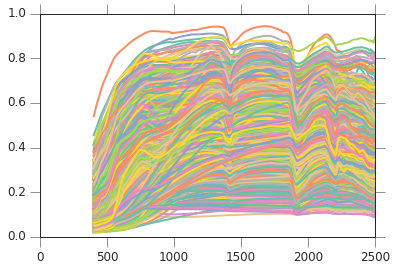

In [872]:
sosp =[]
for i in un:
    f = interpolate.interp1d(swv,i)
    wvmin = 400
    wvmax = 2501
    xnew = range(400,2501)
    ynew = f(xnew)
    fspec = np.zeros(len(wv))
    fspec[wvmin-400:wvmax-400]=ynew
    sosp.append(fspec)
    plt.plot(xnew, fspec)

slope:  1.102 intercept:  0.0051 rvalue:  0.9968 pvalue:  0.0 stderr:  0.0013
slope:  1.0182 intercept:  0.0049 rvalue:  0.9989 pvalue:  0.0 stderr:  0.0007
slope:  1.0155 intercept:  0.0078 rvalue:  0.9993 pvalue:  0.0 stderr:  0.0006
slope:  1.0114 intercept:  -0.0058 rvalue:  0.9985 pvalue:  0.0 stderr:  0.0008
slope:  0.995 intercept:  0.0023 rvalue:  0.9998 pvalue:  0.0 stderr:  0.0003
slope:  0.9979 intercept:  -0.0003 rvalue:  1.0 pvalue:  0.0 stderr:  0.0001
slope:  0.925 intercept:  -0.0007 rvalue:  0.9778 pvalue:  0.0 stderr:  0.003


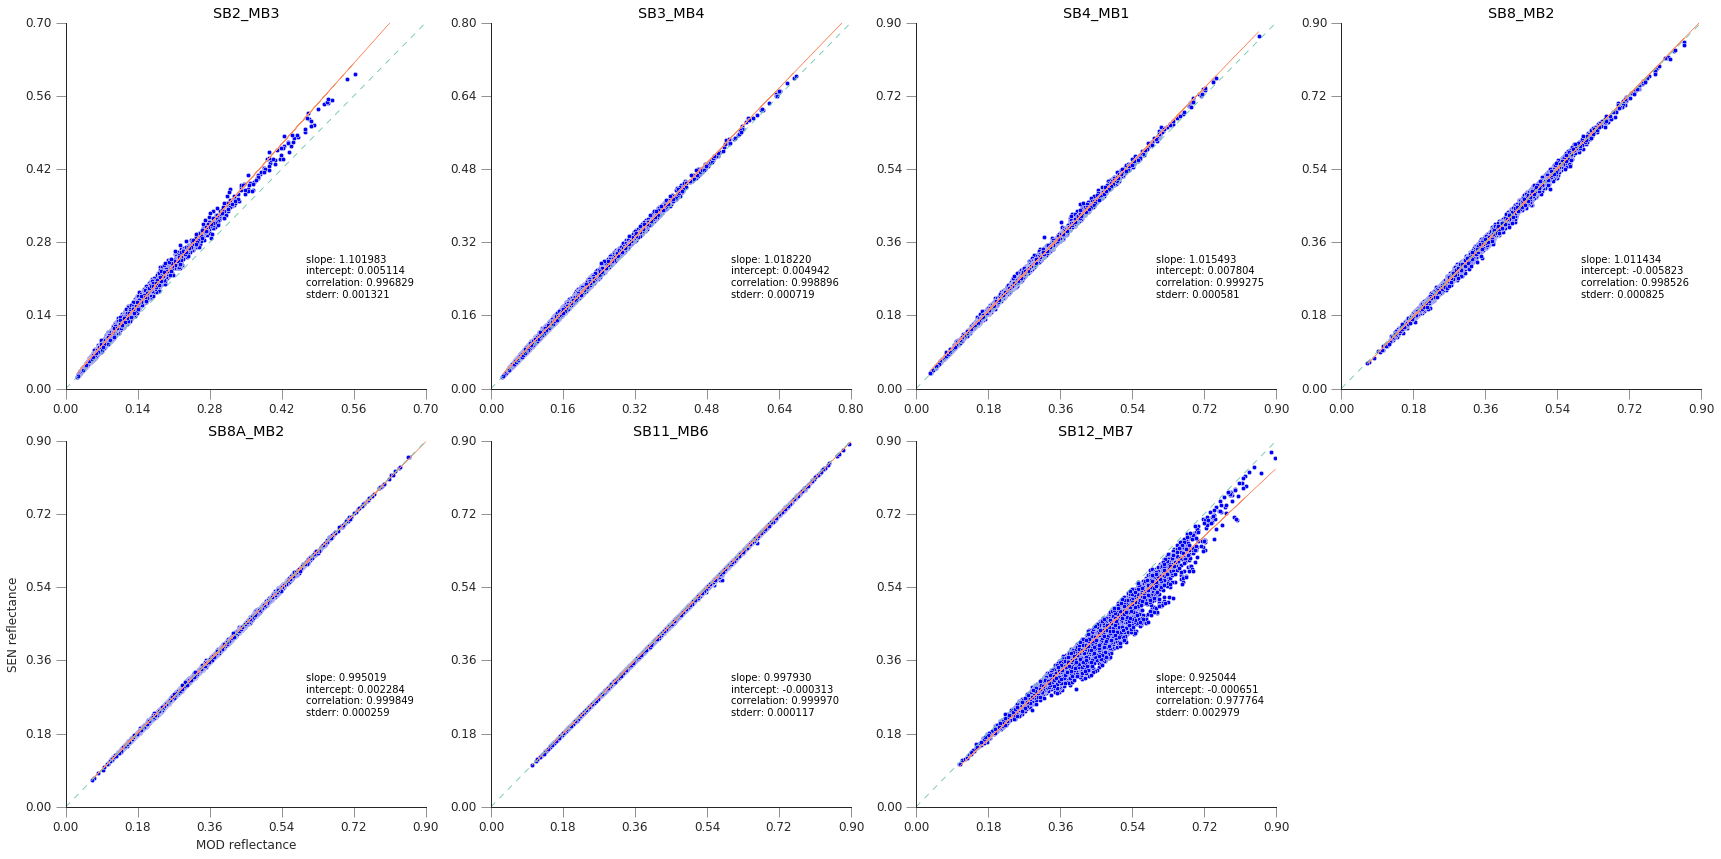

In [878]:
spec4 =  np.array(sosp)
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8A_MB2,SB11_MB6,SB12_MB7').split(',')
mod_spr = '''modis_band1.det  modis_band3.det  modis_band6.det  modis_band2.det  modis_band4.det  modis_band7.det'''.split('  ')
mod_spr = sorted(mod_spr)
sen_rsp = pd.ExcelFile('sp_rep/Sentbands.xlsx')
swl = np.array(sen_rsp.parse('Spectral Responses')['SR_WL'])
fig = plt.figure(figsize=(24,12))
for ii in range(0,7):
    if ii<2:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii+2]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
    elif ii<4:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii-2]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
    elif ii==4:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii-3]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
    else:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii-1]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
         
    
    srsp = np.array(sen_rsp.parse('Spectral Responses')[cname[ii]])[100:2201]
    #w, rsr = swl[srsp!=0],srsp[srsp!=0]
    #passband2 = swl[100:2200]
    mod = np.sum(spec4.T[passband1].T*(ynew/ynew.sum()), axis=-1)
    sen = np.sum(spec4*(srsp/srsp.sum()), axis=-1)
    p = np.polyfit (mod, sen, 1)
    ax = fig.add_subplot(2,4,ii+1)
    ax.scatter(mod,sen, marker='o')
    mval = round(np.max([mod, sen]), 1)
    pretty_axes(ax)
    ax.plot( mod, np.polyval ( p, mod), '-', lw=0.4  )
    ax.plot([0,mval+0.1], [0,mval+0.1], '--', lw=0.8)
    ax.set_title(names[ii])
    ax.set_xlim(0,mval)
    ax.set_ylim(0,mval)
    ax.set_yticks(np.arange(0,mval+0.1,mval/5.))
    ax.set_xticks(np.arange(0,mval+0.1,mval/5.))
    slope,inter, rval, pval, std = linregress(mod, sen)
    ax.text(mval*(4./6.),mval*(1.5/6.),'slope: %02f \nintercept: %02f \ncorrelation: %02f \nstderr: %02f'%(slope,inter, rval, std), 
        )
    if ii==4:
        ax.set_xlabel ( "MOD reflectance")
        ax.set_ylabel ( "SEN reflectance")
    print 'slope: ',round(slope,4), 'intercept: ', round(inter,4), 'rvalue: ',round(rval,4), 'pvalue: ', round(pval,4), 'stderr: ', round(std,4)
plt.tight_layout()

In [890]:
whsp = np.vstack((spec[2], spec2, spec3, spec4))

slope:  1.0716 intercept:  0.0076 rvalue:  0.9944 pvalue:  0.0 stderr:  0.0008
slope:  1.0346 intercept:  -0.0021 rvalue:  0.999 pvalue:  0.0 stderr:  0.0003
slope:  1.0426 intercept:  -0.003 rvalue:  0.9988 pvalue:  0.0 stderr:  0.0004
slope:  0.9854 intercept:  -0.0028 rvalue:  0.9984 pvalue:  0.0 stderr:  0.0004
slope:  1.0036 intercept:  0.0012 rvalue:  0.9996 pvalue:  0.0 stderr:  0.0002
slope:  1.006 intercept:  -0.0065 rvalue:  0.9998 pvalue:  0.0 stderr:  0.0001
slope:  0.9137 intercept:  0.0131 rvalue:  0.9956 pvalue:  0.0 stderr:  0.0006


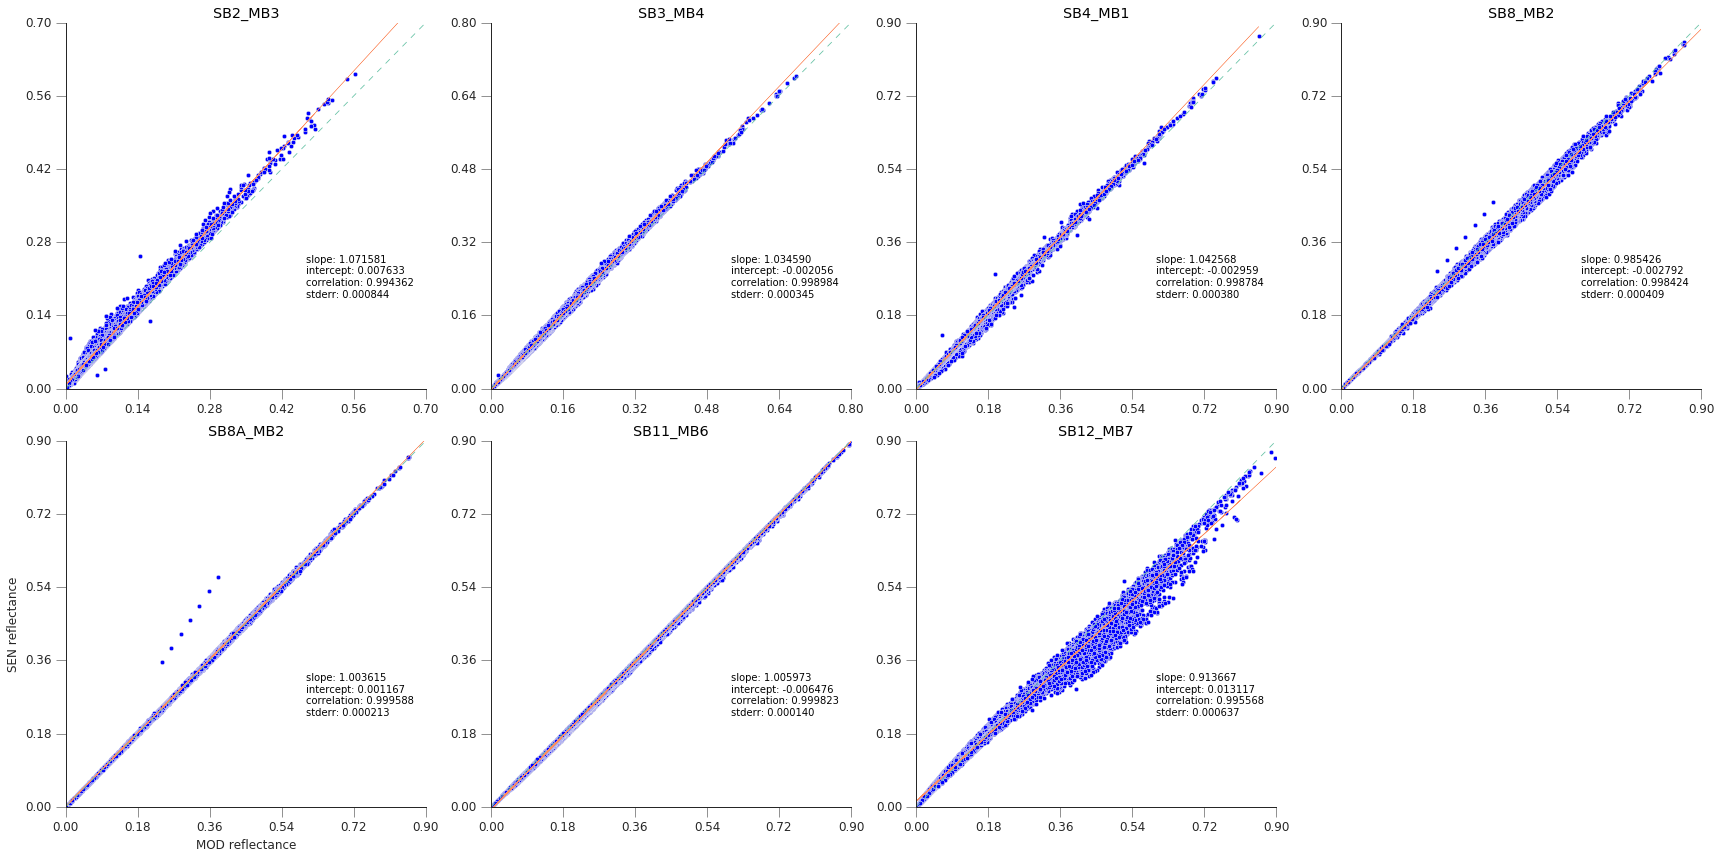

In [940]:
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8A_MB2,SB11_MB6,SB12_MB7').split(',')
mod_spr = '''modis_band1.det  modis_band3.det  modis_band6.det  modis_band2.det  modis_band4.det  modis_band7.det'''.split('  ')
mod_spr = sorted(mod_spr)
sen_rsp = pd.ExcelFile('sp_rep/Sentbands.xlsx')
swl = np.array(sen_rsp.parse('Spectral Responses')['SR_WL'])
fig = plt.figure(figsize=(24,12))
for ii in range(7):
    if ii<2:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii+2]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
    elif ii<4:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii-2]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
    elif ii==4:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii-3]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
    else:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii-1]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
         
    
    srsp = np.array(sen_rsp.parse('Spectral Responses')[cname[ii]])[100:2201]
    #w, rsr = swl[srsp!=0],srsp[srsp!=0]
    #passband2 = swl[100:2200]
    mod = np.sum(whsp.T[passband1].T*(ynew/ynew.sum()), axis=-1)
    sen = np.sum(whsp*(srsp/srsp.sum()), axis=-1)
    dis = mod-sen
    std = np.std(dis)
    mean = np.mean(dis)
    inl = (dis > mean-3*std)&(dis < mean+3*std)
    modin = mod[inl]
    senin = sen[inl]
    modin = mod
    senin = sen
    p = np.polyfit (modin, senin, 1)
    ax = fig.add_subplot(2,4,ii+1)
    ax.scatter(modin,senin, marker='o')
    mval = round(np.max([modin, senin]), 1)
    pretty_axes(ax)
    ax.plot( modin, np.polyval ( p, modin), '-', lw=0.4  )
    ax.plot([0,mval+0.1], [0,mval+0.1], '--', lw=0.8)
    ax.set_title(names[ii])
    ax.set_xlim(0,mval)
    ax.set_ylim(0,mval)
    ax.set_yticks(np.arange(0,mval+0.1,mval/5.))
    ax.set_xticks(np.arange(0,mval+0.1,mval/5.))
    slope,inter, rval, pval, std = linregress(modin, senin)
    ax.text(mval*(4./6.),mval*(1.5/6.),'slope: %02f \nintercept: %02f \ncorrelation: %02f \nstderr: %02f'%(slope,inter, rval, std), 
        )
    if ii==4:
        ax.set_xlabel ( "MOD reflectance")
        ax.set_ylabel ( "SEN reflectance")
    print 'slope: ',round(slope,4), 'intercept: ', round(inter,4), 'rvalue: ',round(rval,4), 'pvalue: ', round(pval,4), 'stderr: ', round(std,4)
plt.tight_layout()

slope:  1.0644 intercept:  0.0078 rvalue:  0.9947 pvalue:  0.0 stderr:  0.0008
slope:  1.0282 intercept:  -0.0017 rvalue:  0.9992 pvalue:  0.0 stderr:  0.0003
slope:  1.0418 intercept:  -0.0028 rvalue:  0.999 pvalue:  0.0 stderr:  0.0004
slope:  0.9863 intercept:  -0.003 rvalue:  0.9987 pvalue:  0.0 stderr:  0.0004
slope:  1.0036 intercept:  0.0011 rvalue:  0.9999 pvalue:  0.0 stderr:  0.0001
slope:  1.0062 intercept:  -0.0065 rvalue:  0.9998 pvalue:  0.0 stderr:  0.0001
slope:  0.9287 intercept:  0.0114 rvalue:  0.9973 pvalue:  0.0 stderr:  0.0005


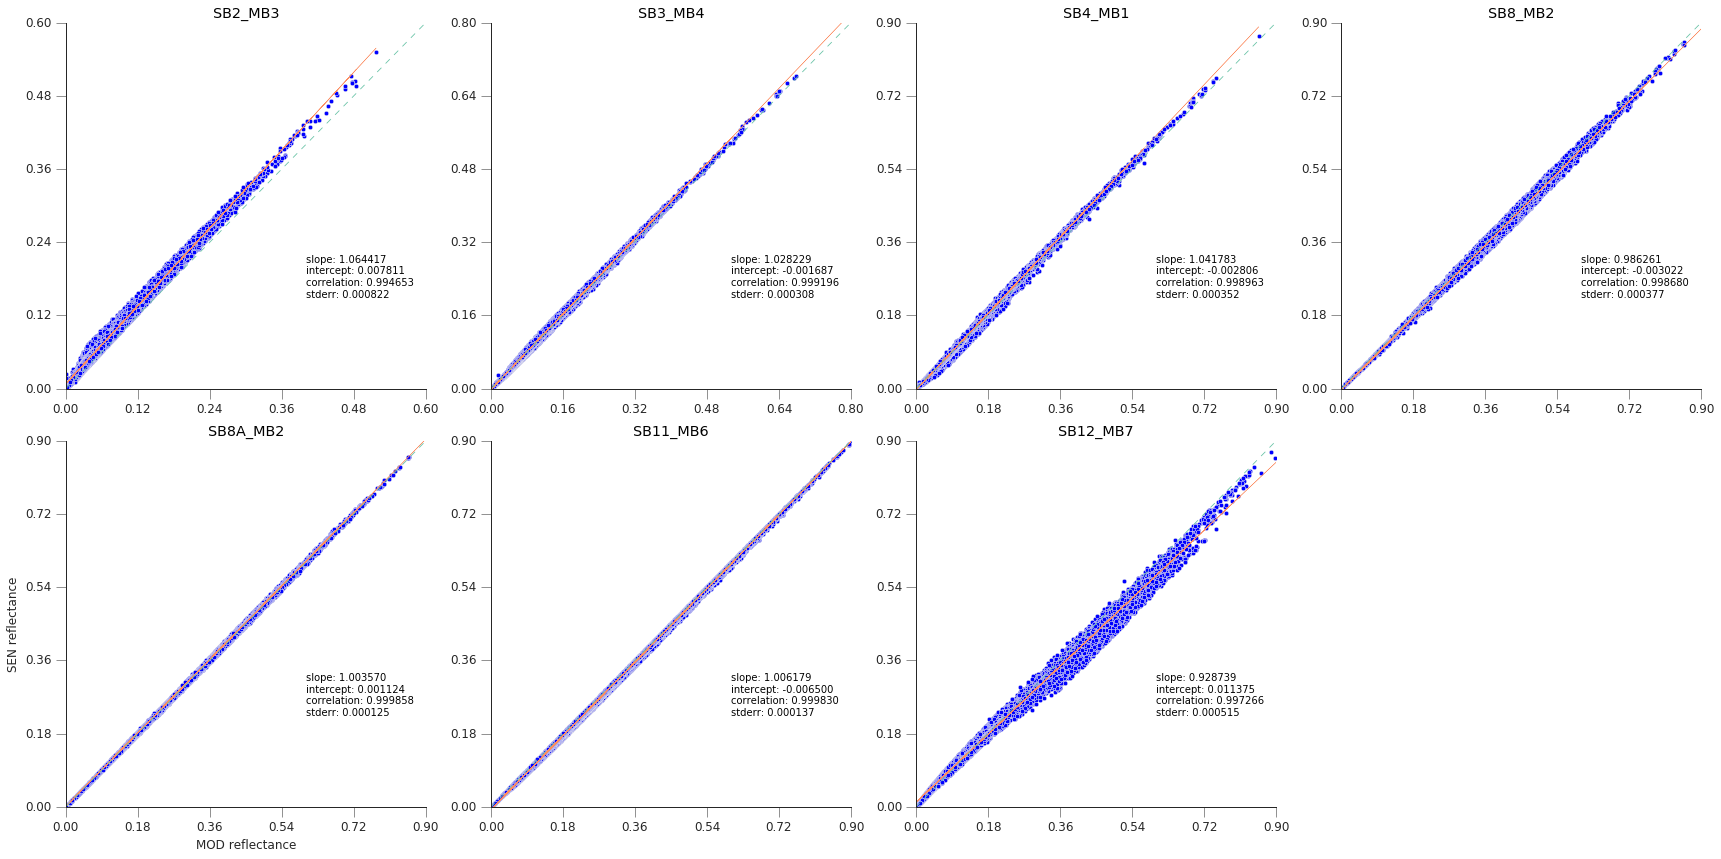

In [943]:
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8A_MB2,SB11_MB6,SB12_MB7').split(',')
mod_spr = '''modis_band1.det  modis_band3.det  modis_band6.det  modis_band2.det  modis_band4.det  modis_band7.det'''.split('  ')
mod_spr = sorted(mod_spr)
sen_rsp = pd.ExcelFile('sp_rep/Sentbands.xlsx')
swl = np.array(sen_rsp.parse('Spectral Responses')['SR_WL'])
fig = plt.figure(figsize=(24,12))
paras=[]
for ii in range(7):
    if ii<2:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii+2]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
    elif ii<4:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii-2]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
    elif ii==4:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii-3]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
    else:
        wl,re= np.loadtxt('sp_rep/'+mod_spr[ii-1]).T[2:]
        data = {j:re[i] for i, j in enumerate(wl)}
        w,r = np.array([[i,data[i]] for i in sorted(data.keys())]).T
        f = interpolate.interp1d(w, r)
        xnew = np.arange(int(min(w))+1, int(max(w)), 1)
        ynew = f(xnew)
        
        passband1 = np.nonzero( np.logical_and ( wv >= xnew.min(), wv <= xnew.max() ) )
         
    
    srsp = np.array(sen_rsp.parse('Spectral Responses')[cname[ii]])[100:2201]
    #w, rsr = swl[srsp!=0],srsp[srsp!=0]
    #passband2 = swl[100:2200]
    mod = np.sum(whsp.T[passband1].T*(ynew/ynew.sum()), axis=-1)
    sen = np.sum(whsp*(srsp/srsp.sum()), axis=-1)
    dis = mod-sen
    std = np.std(dis)
    mean = np.mean(dis)
    inl = (dis > mean-3*std)&(dis < mean+3*std)
    modin = mod[inl]
    senin = sen[inl]
    #modin = mod
    #senin = sen
    p = np.polyfit (modin, senin, 1)
    ax = fig.add_subplot(2,4,ii+1)
    ax.scatter(modin,senin, marker='o')
    mval = round(np.max([modin, senin]), 1)
    pretty_axes(ax)
    ax.plot( modin, np.polyval ( p, modin), '-', lw=0.4  )
    ax.plot([0,mval+0.1], [0,mval+0.1], '--', lw=0.8)
    ax.set_title(names[ii])
    ax.set_xlim(0,mval)
    ax.set_ylim(0,mval)
    ax.set_yticks(np.arange(0,mval+0.1,mval/5.))
    ax.set_xticks(np.arange(0,mval+0.1,mval/5.))
    slope,inter, rval, pval, std = linregress(modin, senin)
    ax.text(mval*(4./6.),mval*(1.5/6.),'slope: %02f \nintercept: %02f \ncorrelation: %02f \nstderr: %02f'%(slope,inter, rval, std), 
        )
    if ii==4:
        ax.set_xlabel ( "MOD reflectance")
        ax.set_ylabel ( "SEN reflectance")
    print 'slope: ',round(slope,4), 'intercept: ', round(inter,4), 'rvalue: ',round(rval,4), 'pvalue: ', round(pval,4), 'stderr: ', round(std,4)
    paras.append([slope, inter])
plt.tight_layout()

In [944]:
paras

[[1.0644166395996226, 0.0078111864941715209],
 [1.0282288683574514, -0.0016868435306524043],
 [1.0417832752129916, -0.0028055504099213091],
 [0.98626120684998164, -0.003021567547191184],
 [1.0035695861714218, 0.0011235267346293987],
 [1.0061788039489881, -0.0064998801286518249],
 [0.9287394597426758, 0.011375159552447944]]

In [927]:
psfs = [[  19.37742268,  340.51569258,    8.55957284,  -19.97494662,
          55.8951623 ,  111.        ],
       [  18.69004701,  350.05439333,    8.58614512,  -19.15739279,
          56.84465371,  100.        ],
       [  17.49415378,  334.1299149 ,    8.24946071,  -22.41469548,
          55.41919643,  103.        ],
       [  18.32483114,  331.71716459,    7.99687234,  -23.25150309,
          56.15568971,  106.        ],
       [  18.87672752,  332.5545401 ,    7.78991191,  -23.5804287 ,
          56.49932225,  105.        ],
       [  32.60327561,  300.02067928,    5.4806016 ,  -23.00220077,
          66.20249948,  129.        ],
       [  24.57625059,  301.22900811,    7.27638375,  -17.52262047,
          71.8024419 ,  114.        ]]

In [946]:
def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

In [929]:
def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

In [ ]:
centers = parallel_rw_pkl(None, 'Sindex', 'r')
data = parallel_rw_pkl(None, 'inter_sent%i'%0, 'r')
mask = parallel_rw_pkl(None, 'inter_sentm%i'%0, 'r')

In [949]:
sent = tiff.imread('corband3.tif', key=0)
sent = ScaleExtent(sent, (10980,10980))
cm = parallel_rw_pkl(None, 'newcloudm', 'r')
sent[cm] = sent[~cm].mean()
data[mask] = np.nan
modis_sent = np.array(data)

In [ ]:
xstd, ystd, angle, xs, ys, wind = psfs[0]
para = paras[0]

cx = centers[0]
cy = centers[1]

gaus = gaussian(wind,wind,xstd,ystd,angle,False)                              
ker = gaus/(gaus.sum())

s = signal.fftconvolve(sent, ker, mode='same')

vld_x = ((cx+xs)>wind/2)&((cx+xs)<10000-wind/2)
vld_y = ((cy+ys)>wind/2)&((cy+ys)<10000-wind/2)
vld = vld_x&vld_y

brdf = modis_sent[cx[vld],cy[vld]]*0.001
indx,indy = np.round((cx+xs)[vld]).astype(int), np.round((cy+ys)[vld]).astype(int)
vals = s[indx,indy]

In [966]:
def atmom(p, TOA_s, BRDF_m, paras): 
    alpha, beta, path_r = p
    a,b, = paras
    semi_sen = a*BRDF_m + b
    cost = abs(TOA_s - path_r - (alpha*semi_sen/(1-beta*semi_sen)))
    return cost

In [977]:
x0 = np.array([1,1,1])
solved = []
def opt(i):
    psolve = optimize.fmin_l_bfgs_b(atmom,x0,p,approx_grad=True, iprint=-1, args=(vals[i], brdf[i], para))
    return [(indx[i], indy[i]),psolve]

In [992]:
pool = multiprocessing.Pool(processes = 16)
retval = pool.map(opt, range(len(vals)))
pool.close()
pool.join()

In [1013]:
pars = [[[i[0][0],i[0][1]]+i[1][0].tolist()] for i in retval]

In [1018]:
pars = np.array(pars).reshape(45574,5)

In [1020]:
a = np.zeros((10000,10000))

In [1029]:
a[pars.T[0].astype(int), pars.T[1].astype(int)] = pars.T[2]

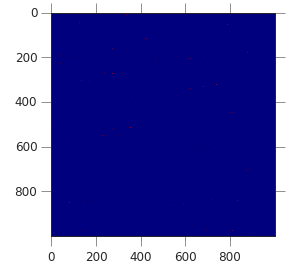

In [1031]:
plt.imshow(a[::10,::10])